# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/labbeti/anaconda3/envs/env_ssl/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import datetime
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Utility functions

In [5]:
def track_maximum():
    def func(key, value):
        if key not in func.max:
            func.max[key] = value
        else:
            if func.max[key] < value:
                func.max[key] = value
        return func.max[key]

    func.max = dict()
    return func


def get_datetime():
    now = datetime.datetime.now()
    return str(now)[:10] + "_" + str(now)[11:-7]


def reset_seed(seed):
    import random

    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    numpy.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Arguments

In [6]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="SpeechCommand", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="cnn03", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=128, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.1, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--preload_dataset", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../results/model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../results/tensorboard_leo/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [7]:
args

Namespace(batch_size=128, checkpoint_path='supervised', checkpoint_root='../results/model_save/', dataset='SpeechCommand', dataset_root='../datasets', from_config='', learning_rate=0.1, model='cnn03', nb_epoch=200, num_classes=10, preload_dataset=False, resume=False, seed=1234, supervised_ratio=1.0, tensorboard_path='supervised', tensorboard_root='../results/tensorboard_leo/', tensorboard_sufix='', train_folds=[1, 2, 3, 4], val_folds=[5])

# initialisation

In [8]:
reset_seed(args.seed)


# Prepare the dataset

In [9]:
train_transform = transforms.Compose([
    transforms.RandomAffine(0, translate=(1/16, 1/16)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
def _split_s_u(train_dataset, s_ratio: float = 0.08, nb_class: int = 10):
    if s_ratio == 1.0:
        return list(range(len(train_dataset))), []

    s_idx, u_idx = [], []
    nb_s = int(np.ceil(len(train_dataset) * s_ratio) // nb_class)
    cls_idx = [[] for _ in range(nb_class)]

    # To each file, an index is assigned, then they are split into classes
    for i in range(len(train_dataset)):
        _, y = train_dataset[i]
        cls_idx[y].append(i)

    for i in range(len(cls_idx)):
        random.shuffle(cls_idx[i])
        s_idx += cls_idx[i][:nb_s]
        u_idx += cls_idx[i][nb_s:]

    return s_idx, u_idx


def load_supervised(
        dataset_root,
        supervised_ratio: float = 1.0,
        batch_size: int = 128,
        train_transform: list = [],
        val_transform: list = [],
        **kwargs
):
    """
    Load the cifar10 dataset for Deep Co Training system.
    """

    train_dataset = torchvision.datasets.CIFAR10(root=os.path.join(dataset_root, "CIFAR10"), train=True, download=True, transform=train_transform)
    val_dataset = torchvision.datasets.CIFAR10(root=os.path.join(dataset_root, "CIFAR10"), train=False, download=True, transform=val_transform)

    # Split the training dataset into a supervised and unsupervised sets
    s_idx, u_idx = _split_s_u(train_dataset, supervised_ratio)

    sampler_s1 = data.SubsetRandomSampler(s_idx)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler_s1, num_workers=4, pin_memory=True, )
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, )

    return None, train_loader, val_loader

In [11]:
manager, train_loader, val_loader = load_supervised(
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=train_transform,
    val_transform=val_transform,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2
)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
input_shape = train_loader.dataset[0][0].shape

# Prep model

## modification of pytorch wideresnet implementation

In [13]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        
        self.expansion = 2

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, layers, width: int = 2, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=16, replace_stride_with_dilation=None,
                 norm_layer=None):
        nn.Module.__init__(self)
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        block = BasicBlock
        self.inplanes = 16*width
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 16*width, layers[0])
        self.layer2 = self._make_layer(block, 32*width, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 64*width, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64* width * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [14]:
def wideresnet28_2(**kwargs):
    return ResNet([4, 4, 4], num_classes=10)

## Create the model

In [15]:
torch.cuda.empty_cache()

model_func = wideresnet28_2

model = model_func(input_shape=input_shape, num_classes = args.num_classes)
model = model.cuda()


In [16]:
from torchsummary import summary

s = summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           9,216
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,216
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
       BasicBlock-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]           9,216
      BatchNorm2d-13           [-1, 32, 16, 16]              64
             ReLU-14           [-1, 32,

# training parameters

In [17]:
# tensorboard
title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__, args.supervised_ratio)
tensorboard_title = "%s/%sS/%s_%s_%.1fS" % title_element

title_element = (model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % title_element

tensorboard = SummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean")

../results/tensorboard_leo/SpeechCommand/supervised/cnn03/1.0S/2020-12-14_16:52:57_wideresnet28_2_1.0S


In [18]:
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)

In [19]:
tensorboard.add_hparams(tensorboard_params, {})

## optimizer

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)

## callbacks

In [21]:
def lr_lambda(e):
    if e < 60:
        return 1

    elif 60 <= e < 120:
        return 0.2

    elif 120 <= e < 160:
        return 0.04

    else:
        return 0.008

lr_scheduler = LambdaLR(optimizer, lr_lambda)
callbacks = [lr_scheduler]

## Checkpoint and metrics

In [22]:
# Checkpoint
# checkpoint = CheckPoint(model, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

# Metrics
fscore_fn = FScore()
acc_fn = CategoricalAccuracy()
avg = ContinueAverage()

maximum_tracker = track_maximum()

reset_metrics = lambda : [m.reset() for m in [fscore_fn, acc_fn, avg]]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## training function

In [23]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

header = header_form.format(
    ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
)


train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  


In [24]:
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()
        
        logits = model(X)        
        loss = loss_ce(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y)  # .mean
            fscore = fscore_fn(pred, y_one_hot)  # .mean
            avg_ce = avg(loss.item())  # .mean

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/Lce", avg_ce, epoch)
    tensorboard.add_scalar("train/f1", fscore, epoch)
    tensorboard.add_scalar("train/acc", acc, epoch)

In [25]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            loss = loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y)  # .mean
            fscore = fscore_fn(pred, y_one_hot)  # .mean
            avg_ce = avg(loss.item())  # .mean

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/Lce", avg_ce, epoch)
    tensorboard.add_scalar("val/f1", fscore, epoch)
    tensorboard.add_scalar("val/acc", acc, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    
    tensorboard.add_scalar("max/acc", maximum_tracker("acc", acc), epoch )
    tensorboard.add_scalar("max/f1", maximum_tracker("f1", fscore), epoch )

    # checkpoint.step(acc)
    for c in callbacks:
        c.step()


In [26]:
print(header)

start_epoch = 0
end_epoch = 200

for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()
tensorboard.close()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          1.6960 -           0.3759    | 0.2300   - 7.3532
Validati 1      - 100    -          1.6200 -           0.4131    | 0.3272   - 0.4775
Training 2      - 100    -          1.2157 -           0.5621    | 0.5113   - 7.3837
Validati 2      - 100    -          1.3933 -           0.5247    | 0.5034   - 0.4665
Training 3      - 100    -          1.0075 -           0.6451    | 0.6212   - 7.2352
Validati 3      - 100    -          1.1222 -           0.5956    | 0.5796   - 0.4756
Training 4      - 100    -          0.8781 -           0.6934    | 0.6804   - 7.4696
Validati 4      - 100    -          1.2931 -           0.5295    | 0.5133   - 0.4682
Training 5      - 100    -          0.7682 -           0.7331    | 0.7263   - 7.2402
Validati 5      - 100    -          1.0427 -           0.6476    | 0.6463   - 0.4872
Training 6      - 100    -          0.7103 -           0.7546 

## display

AttributeError: 'SummaryWriter' object has no attribute 'history'

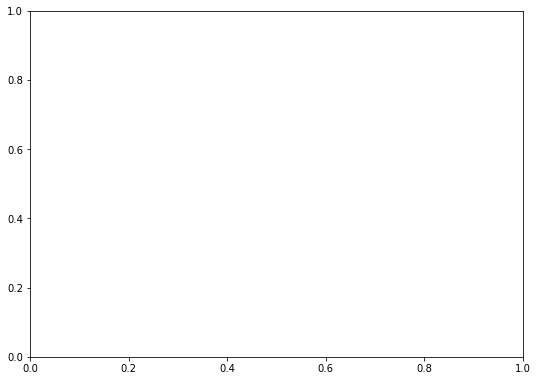

In [27]:
import matplotlib.pyplot as plt

x = list(range(200))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc")
pp("val/f1")
plt.legend()

plt.subplot(2, 3, 3)
pp("detail_hyperparameters/learning_rate")
plt.legend()

plt.show()

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪